https://drive.google.com/file/d/1hSL15Y-M8SvOfMyIYKurV-SsNnDazjYj/view?usp=share_link

In [1]:
! gdown -- 1hSL15Y-M8SvOfMyIYKurV-SsNnDazjYj

Downloading...
From: https://drive.google.com/uc?id=1hSL15Y-M8SvOfMyIYKurV-SsNnDazjYj
To: /content/Аналитик_РБК_тестовое задание.xlsx - Исходные данные.csv
100% 27.9k/27.9k [00:00<00:00, 27.3MB/s]


# Подготовка данных


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
pd.set_option('display.float_format', '{:,.2f}'.format)

import random
import math as mt
from math import factorial
from scipy.stats import norm
from scipy import stats as st
from prophet import Prophet


In [3]:
df = pd.read_csv('/content/Аналитик_РБК_тестовое задание.xlsx - Исходные данные.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Интервал дат визита  731 non-null    object
 1   Визиты               731 non-null    object
 2   Посетители           731 non-null    object
 3   Просмотры            731 non-null    object
dtypes: object(4)
memory usage: 23.0+ KB


Данные открылись без замечаний. Пропусков нет. Приведем колонки к нужному нам типу.

In [5]:
df['Интервал дат визита'] = pd.to_datetime(df["Интервал дат визита"])

In [6]:
df['Визиты'] = df['Визиты'].str.replace('\s', '').astype('int')
df['Посетители'] = df['Посетители'].str.replace('\s', '').astype('int')
df['Просмотры'] = df['Просмотры'].str.replace('\s', '').astype('int');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Проверим дубликаты. 

In [7]:
df.duplicated().sum()

0

Дубликатов нет. Создадим дополнительные колонки для удобства периодизации данных.

In [8]:
df['week'] = df['Интервал дат визита'].dt.isocalendar().week
df['month'] = df['Интервал дат визита'].dt.month
df['year'] = df['Интервал дат визита'].dt.isocalendar().year

Рассмотрим распределение даных.

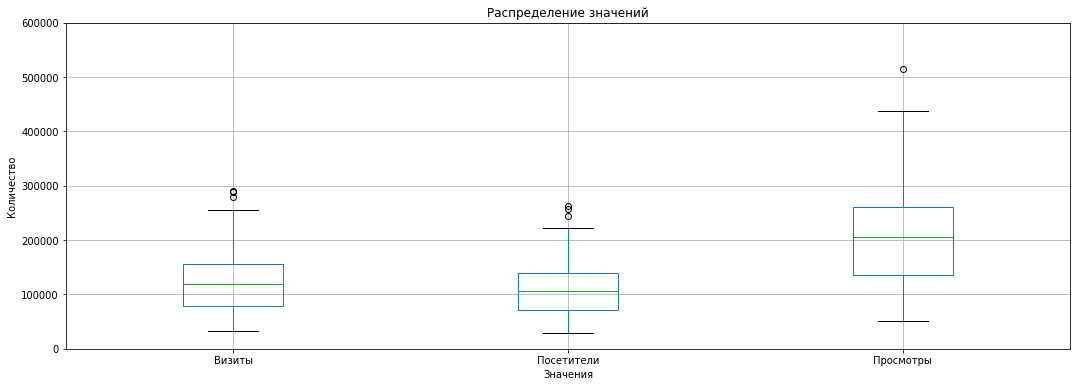

In [9]:
df[['Визиты', 'Посетители', 'Просмотры']].boxplot( figsize=(18, 6))

plt.ylim([0,600000])
plt.title('Распределение значений')
plt.ylabel('Количество')
plt.xlabel('Значения');

Распределение по визитам и посетителям не вызывает подозрений. Распределение по просмотрам стоит рассмотреть детальнее на предмет выбросов.

In [10]:
df['Просмотры'].describe()

count         731.00
mean      205,305.27
std        99,849.14
min        50,256.00
25%       135,730.50
50%       206,519.00
75%       260,972.00
max     1,686,948.00
Name: Просмотры, dtype: float64

При среднем значении в 205 тысяч просмотров и медиане в 206,5 тысяч наблюдаем единичное значение в почти 1 млн 700 тысяч просмотров за один день. Найдем его.

In [11]:
df.loc[df['Просмотры'] == df['Просмотры'].describe()[7]]

,Интервал дат визита,Визиты,Посетители,Просмотры,week,month,year
700,2016-12-01,130825,117165,1686948,48,12,2016


Рассмотрим данные по соседству.

In [12]:
df.loc[695:710]

,Интервал дат визита,Визиты,Посетители,Просмотры,week,month,year
695,2016-11-26,53805,50629,84360,47,11,2016
696,2016-11-27,49292,46376,77411,47,11,2016
697,2016-11-28,90619,81817,158161,48,11,2016
698,2016-11-29,90535,81967,160768,48,11,2016
699,2016-11-30,108494,97868,404737,48,11,2016
700,2016-12-01,130825,117165,1686948,48,12,2016
701,2016-12-02,104664,95230,222917,48,12,2016
702,2016-12-03,49746,46391,111591,48,12,2016
703,2016-12-04,53043,49320,114266,48,12,2016
704,2016-12-05,97578,88975,220852,49,12,2016


Значение в 1 млн 700 тысяч просмотров очень похоже на выброс. Мониторинг новостей за 1 декабря 2016 года не выявил особых событий, которые могли подстегнуть к столь резкому росту просмотров на сайте РБК. Возможно, это значение попало в датафрейм в результате ошибки при выгрузке данных. В любом случае, при дальнейшем исследовании будем использовать медианные значения, чтобы избежать искажения результатов из-за возможных выбросов.

## Показать понедельную динамику посещаемости сайта за сентябрь-ноябрь 2016. Показатели: визиты, просмотры, среднедневное кол-во визитов на посетителя																

In [13]:
df_sen_nov_2016 = df.loc[(df['Интервал дат визита'] >= "2016-09-01") & (df['Интервал дат визита'] <= "2016-11-30")]


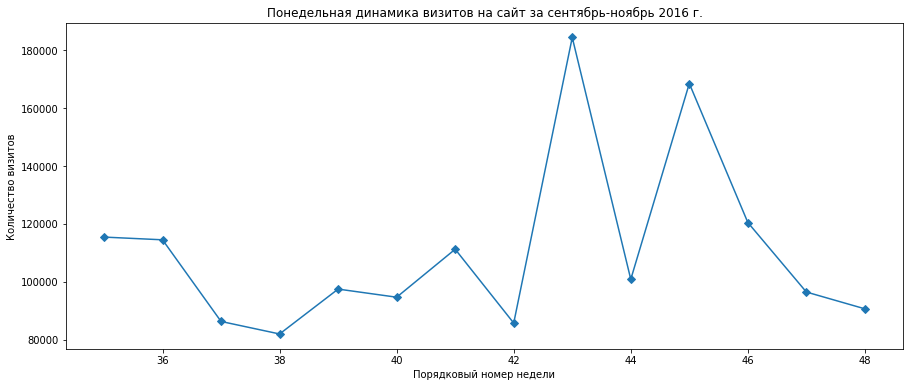

In [14]:
df_sen_nov_2016.groupby('week')['Визиты'].median().plot(figsize=(15, 6), marker='D')

plt.title('Понедельная динамика визитов на сайт за сентябрь-ноябрь 2016 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Количество визитов');

In [15]:
vizits = df_sen_nov_2016.groupby('week')['Визиты'].median().reset_index().sort_values(by='Визиты', ascending = False)

vizits = vizits.rename(columns = {'week':'Порядковый № недели'})
vizits

,Порядковый № недели,Визиты
8,43,"184,392.00"
10,45,"168,484.00"
11,46,"120,450.00"
0,35,"115,416.50"
1,36,"114,474.00"
6,41,"111,217.00"
9,44,"100,819.00"
4,39,"97,445.00"
12,47,"96,425.00"
5,40,"94,637.00"


Пиковые значения визитов выпали на 43-ю (24-30.10.2016) и 45-ю (07-13.11.2016) неделю. 184000 и 168000 соответственно. В остальные недели медианные визиты не превышают 120000. Самый низкий показатель у 38-й недели (19-25.09.2016) - 82000.

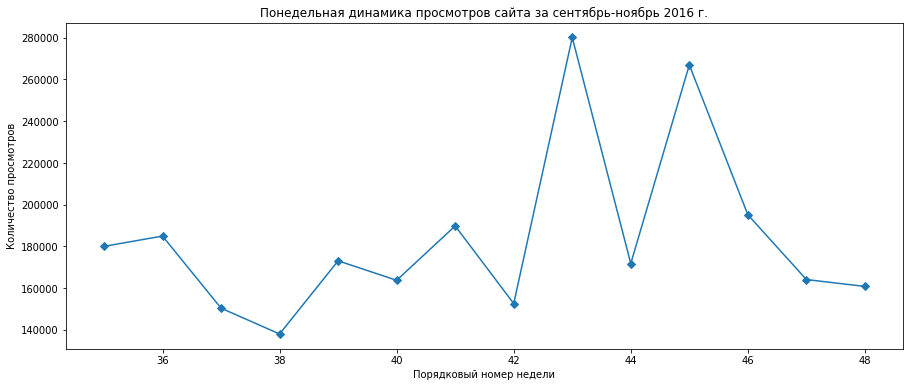

In [16]:
df_sen_nov_2016.groupby('week')['Просмотры'].median().plot(figsize=(15, 6), marker='D')

plt.title('Понедельная динамика просмотров сайта за сентябрь-ноябрь 2016 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Количество просмотров');

In [17]:
view = df_sen_nov_2016.groupby('week')['Просмотры'].median().reset_index().sort_values(by='Просмотры', ascending = False)

view = view.rename(columns = {'week':'Порядковый № недели'})
view

,Порядковый № недели,Просмотры
8,43,"280,121.00"
10,45,"266,950.00"
11,46,"195,132.00"
6,41,"189,777.00"
1,36,"184,911.00"
0,35,"179,983.00"
4,39,"173,049.00"
9,44,"171,753.00"
12,47,"164,068.00"
5,40,"163,708.00"


Картина, аналогичная динамике визитов. В лидерах 43-я и 45-я недели. В аутсайдерах - 38-я.

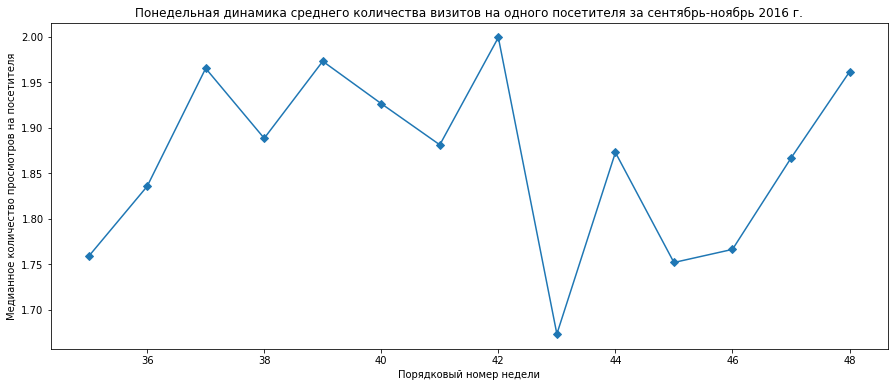

In [18]:
((df_sen_nov_2016.groupby('week')['Просмотры'].median()) / (df_sen_nov_2016.groupby('week')['Посетители'].median())).plot(figsize=(15, 6), marker='D')

plt.title('Понедельная динамика среднего количества визитов на одного посетителя за сентябрь-ноябрь 2016 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Медианное количество просмотров на посетителя');

In [19]:
avg_client = ((df_sen_nov_2016.groupby('week')['Просмотры'].median()) / (df_sen_nov_2016.groupby('week')['Посетители']\
                                                                         .median())).round(2).reset_index()\
                                                                         .sort_values(by=0, ascending = False)

avg_client.columns = ['Порядковый № недели', 'Медианное количество визитов на посетителя']
avg_client

,Порядковый № недели,Медианное количество визитов на посетителя
7,42,2.00
2,37,1.97
4,39,1.97
13,48,1.96
5,40,1.93
3,38,1.89
6,41,1.88
9,44,1.87
12,47,1.87
1,36,1.84


42-я неделя (17-23.10.2016) внизу таблиц динамики визитов и просмототров, однако больше всего визитов на одного посетителя выпало на нее. У 43-ей и 45-ой  недель, которые в лидерах по визитам и просмотрам, меньше всего визитов на одного посетителя.  

## Рассчитать по каждой отчётной неделе (пн-вс) изменение за неделю и за год (неделя 2016 г. к той же неделе 2015 г.)											

Разобьем данные на две таблицы по годам и подготовим медианные значения по отчетным неделям. 

In [20]:
df_2015 = df.loc[df['year'] == 2015].groupby('week').agg({'Визиты': 'median',	'Посетители': 'median',	'Просмотры': 'median'})

In [21]:
df_2016 = df.loc[df['year'] == 2016].groupby('week').agg({'Визиты': 'median',	'Посетители': 'median',	'Просмотры': 'median'})

Объединим датафрейм в один, совместив сведения по совпадающим отчетным неделям за два года (в итоговую таблицу войдут 52 недели, так как в 53-й отчетной неделе  2015-го года пересекаются 2015 и 2016 год, а в 53-й отчетной неделе 2016-го года не хватает данных за несколько дней 2017-го года).

In [22]:
df_common = df_2015.merge(df_2016, how='inner', on='week')
df_common.columns = ['Визиты_2015',	'Посетители_2015',	'Просмотры_2015',	'Визиты_2016',	'Посетители_2016',	'Просмотры_2016']

Рассчитаем изменения.

In [23]:
df_common['Визиты_Изменения, %'] = (df_common['Визиты_2016'] / df_common['Визиты_2015'] *100)-100
df_common['Посетители_Изменения, %'] = (df_common['Посетители_2016'] / df_common['Посетители_2015'] *100)-100
df_common['Просмотры_Изменения, %'] = (df_common['Просмотры_2016'] / df_common['Просмотры_2015'] *100)-100

Визуализируем результат.

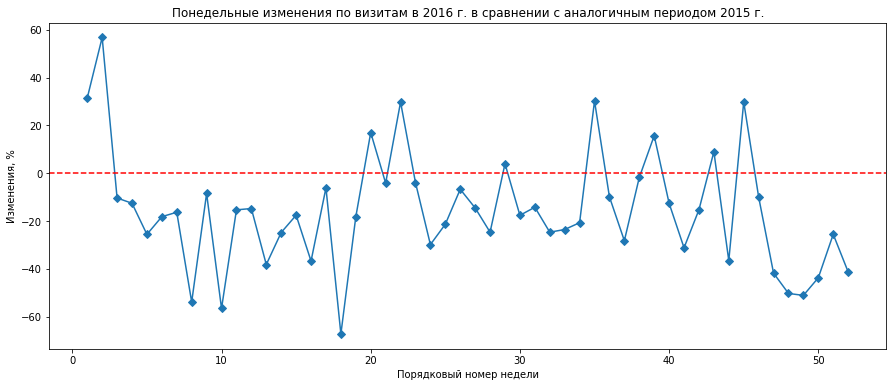

In [24]:
df_common['Визиты_Изменения, %'].plot(figsize=(15, 6), marker='D')

plt.axhline(y=0, color='red', linestyle='--')
plt.title('Понедельные изменения по визитам в 2016 г. в сравнении с аналогичным периодом 2015 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Изменения, %');

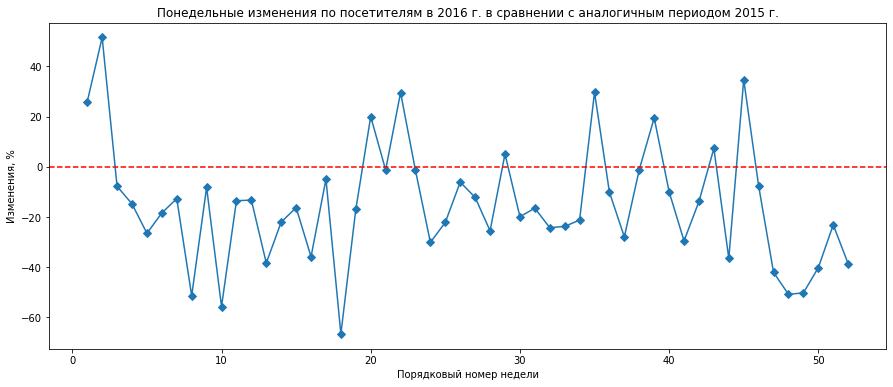

In [25]:
df_common['Посетители_Изменения, %'].plot(figsize=(15, 6), marker='D')

plt.axhline(y=0, color='red', linestyle='--')
plt.title('Понедельные изменения по посетителям в 2016 г. в сравнении с аналогичным периодом 2015 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Изменения, %');

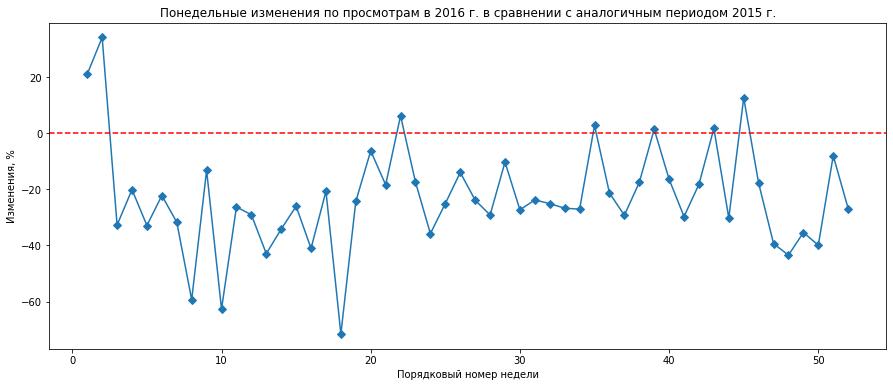

In [26]:
df_common['Просмотры_Изменения, %'].plot(figsize=(15, 6), marker='D')

plt.axhline(y=0, color='red', linestyle='--')
plt.title('Понедельные изменения по просмотрам в 2016 г. в сравнении с аналогичным периодом 2015 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Изменения, %');

Судя по понедельному сравнению, в 2016-м году наблюдается ухудшение всех показателей. Плачевнее всего выглядит ситуация с просмотрами. Сравним медианные показатели 2016-го года в сравнении с 2015-м.

In [27]:
table = pd.DataFrame(np.array([['Визиты', ((df_common['Визиты_2016'].median() / df_common['Визиты_2015'].median() * 100) - 100).round(2), '%'], 
                               ['Посетители', ((df_common['Посетители_2016'].median() / df_common['Посетители_2015'].median() * 100) - 100).round(2), '%'],
                             ['Просмотры', ((df_common['Просмотры_2016'].median() / df_common['Просмотры_2015'].median() * 100) - 100).round(2), '%']]),
                   columns=['', 'Медианные изменения по итогам 2016 г. в сравнении с предыдущим', ''])\
                   .sort_values(by='Медианные изменения по итогам 2016 г. в сравнении с предыдущим', ascending = False).style.hide_index()
                   
table

,Медианные изменения по итогам 2016 г. в сравнении с предыдущим,
Просмотры,-24.26,%
Визиты,-14.92,%
Посетители,-14.9,%


Да, заметнее всего - падение просмотров. Они сократились почти на четверть.

## Построить помесячный прогноз трафика на 2017 год (по визитам)							

Для начала рассмотрим динамику визитов за два года, данные о которых у нас есть.

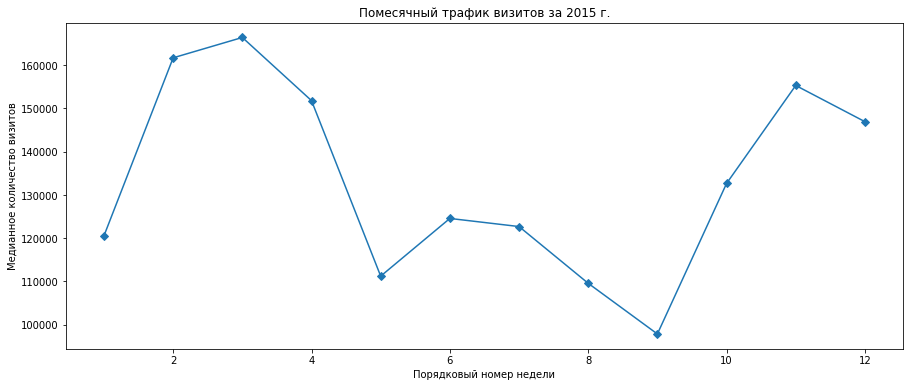

In [28]:
df.loc[df['year'] == 2015].groupby('month')['Визиты'].median().plot(figsize=(15, 6), marker='D')

plt.title('Помесячный трафик визитов за 2015 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Медианное количество визитов');

Анализ помесячной динамики показывает, что весь 2015 г. наблюдались сильные колебания по визитам на сайт. От более чем 160 тыс. визитов в марте до менее 100 тыс. визитов в сентябре. 

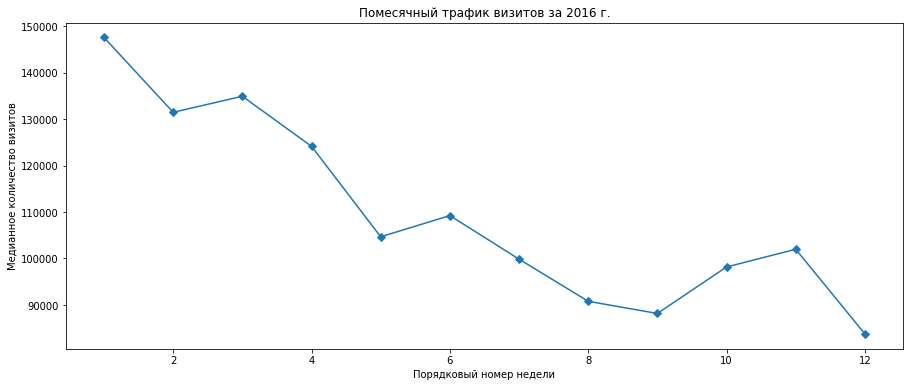

In [29]:
df.loc[df['year'] == 2016].groupby('month')['Визиты'].median().plot(figsize=(15, 6), marker='D')

plt.title('Помесячный трафик визитов за 2016 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Медианное количество визитов');

А вот весь 2016 г. количество визитов падало с небольшим отскоком осенью.

Интересно, как эти данные обработает машина, чтобы составить прогноз по визитам на 2017 г.? 

Для прогнозирования будем использовать автоматизированную библиотеку Prophet, которая использует API библиотеки машинного обучения Sklearn.

In [30]:
df_forecast = df[['Интервал дат визита', 'Визиты']] #готовим матрицу
df_forecast.columns = ['ds', 'y']

In [31]:
m = Prophet(daily_seasonality=False) #анализируем имеющиеся данные, исходя из сезонности. 
                                     #Параметр daily_seasonality указывает, что у нас нет данных, детальнее, чем сведения за один день.
m.fit(df_forecast);

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2thyd8fc/bf3n07hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2thyd8fc/g4eqt4dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38631', 'data', 'file=/tmp/tmp2thyd8fc/bf3n07hk.json', 'init=/tmp/tmp2thyd8fc/g4eqt4dg.json', 'output', 'file=/tmp/tmp2thyd8fc/prophet_modelvqe8liog/prophet_model-20221106104557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
future = m.make_future_dataframe(periods=365) #закладываем прогноз на год

In [33]:
forecast = m.predict(future)

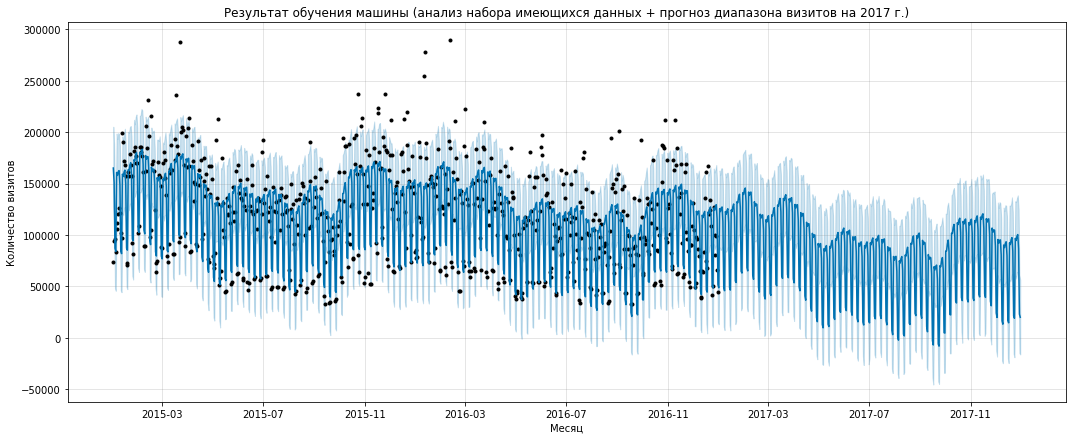

In [34]:
fig1 = m.plot(forecast, figsize=(15, 6))

plt.title('Результат обучения машины (анализ набора имеющихся данных + прогноз диапазона визитов на 2017 г.)')
plt.xlabel('Месяц')
plt.ylabel('Количество визитов');

Машина спрогнозировала снижение показателей по визитам в 2017 г. На графике наблюдается падающий тренд. Проверим данный показатель.


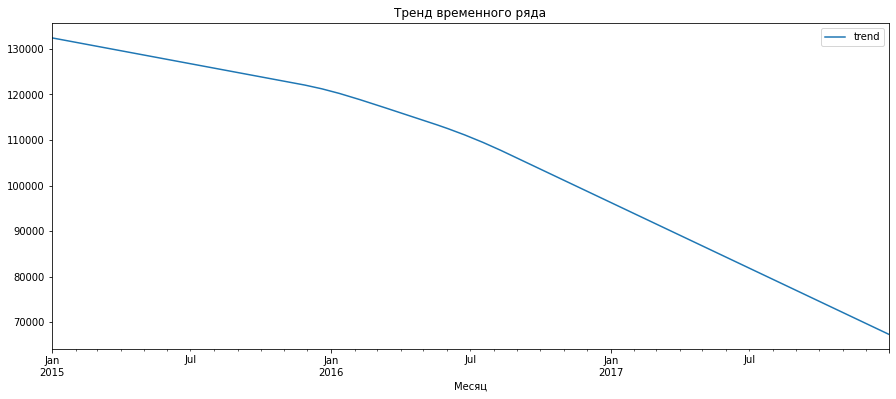

In [35]:
forecast.plot(x = 'ds', y='trend', figsize=(15, 6))

plt.title('Тренд временного ряда')
plt.xlabel('Месяц');

Тренд выглядит устойчивым для временного ряда, значительных изменений тренда не видим.


Рассмотрим подробнее диапазон прогнозных значений на основе имеющихся данных.

In [36]:
forecast_2017 = forecast.loc[forecast['ds'] >= '2017-01-01'].copy()

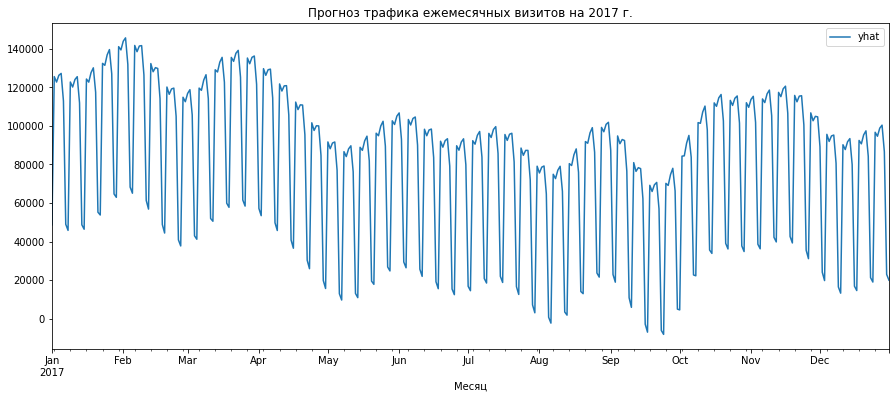

In [37]:
forecast_2017.plot(x = 'ds', y='yhat', figsize=(15, 6))

plt.title('Прогноз трафика ежемесячных визитов на 2017 г.')
plt.xlabel('Месяц');

Рассчитаем медианные значения визитов на каждый месяц 2017 г. на основе прогноза модели машинного обучения.

In [38]:
forecast_2017['month_gr'] = forecast_2017['ds'].dt.month

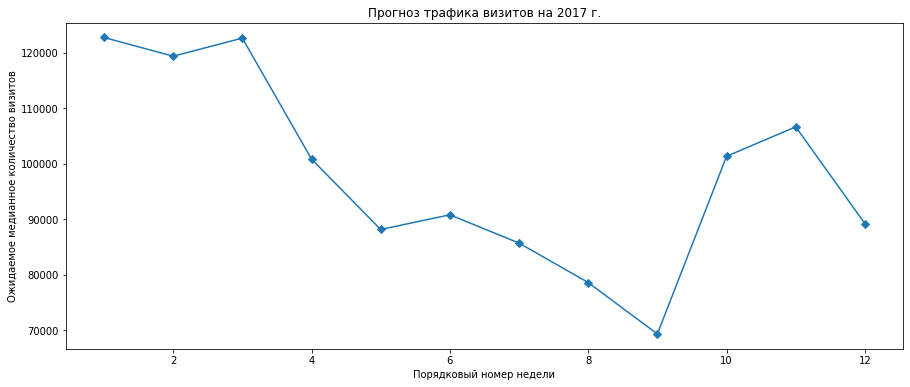

In [39]:
forecast_2017.groupby('month_gr')['yhat'].median().plot(figsize=(15, 6), marker='D')

plt.title('Прогноз трафика визитов на 2017 г.')
plt.xlabel('Порядковый номер недели')
plt.ylabel('Ожидаемое медианное количество визитов');

Машина проанализировала сезонность показателей визитов за два года и пришла к выводу, что с января и до конца лета 2017-го г. количество визитов будет падать. Наименьшее число визитов ожидается в сентябре. Далее машина прогнозирует рост визитов до конца осени и небольшую коррекцию к декабрю. 